<a href="https://colab.research.google.com/github/taynanmancilla/Predicao_do_Preco_de_acoes/blob/main/Predi%C3%A7%C3%A3o_do_Pre%C3%A7o_de_a%C3%A7%C3%B5es.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predição do Preço de ações

Taynan Mancilla

Engenharia de Computação

Inteligência Artificial

In [ ]:
!pip install yfinance
import yfinance as yf
import pandas as pd
from pandas_datareader import data as pdr
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None

## 1. Tratando os dados

A ação em questão sera da Magazine Luiza,foram testados outros ativos como Petrobras e Vale,porém os melhores resultados foram com Magalu


Os dados serão puxados da YahooFinance desde 2014 até o último dia útil da entrega




In [23]:
ativo = "MGLU3.SA"

inicio = "2014-12-31"
fim = "2022-12-09"

papel = yf.download(ativo, start=inicio, end=fim)

[*********************100%***********************]  1 of 1 completed


Sera utilizado para a predição os valores de fechamento do ativo que estão na coluna 'Close'.

Não sera utilizado a coluna de Fechamento Ajustado (adj close) pois não 
são os valores reais da ação, esses valores são ajustados para um cálculo de retorno baseado em dividendos, logo são valores que o Ativo nunca possuiu

---
Sera atribuido apenas a coluna 'Close' a um objeto, convertendo-o de DataFrame para Array com o *to_numpy()* e logo em seguida formatando para matriz de uma coluna com o *reshape()*

In [24]:
fechamento = papel['Close']
fechamento = fechamento.to_numpy()
fechamento = fechamento.reshape(-1, 1)

## 2. Treinando o Modelo

Primeiro vamos pegar apenas o tamanho de dados de treinamento, definindo-o em 80%, para usar no escalador

Note que o resultado foi de 1574 dias

In [25]:
size_train = int(len(fechamento)*0.8)

size_train

1578

Agora vamos escalar os dados de treinamento e de teste, separadamente, entre 0 e 1 para facilitar o processamento utilizando o **MinMaxScaler**

Note que esta sendo usado Fatiamento para dividir os dados

Juntamos os dois conjuntos de dados em 'dados_escalados' para formar o conjunto completo e por fim convertemos esse conjunto para um array (np.array()) de apenas uma coluna (reshape())

In [26]:
escalador = MinMaxScaler(feature_range=(0, 1))

E_train = escalador.fit_transform(fechamento[0: size_train, :])

E_test = escalador.fit_transform(fechamento[size_train: , :])

dados_escalados = list(E_train.reshape(len(E_train))) + list(E_test.reshape(len(E_test)))

dados_escalados = np.array(dados_escalados).reshape(len(dados_escalados), 1)

Vamos criar duas listas: X_train(onde colocaremos os dados que serão usados para gerar o resultado) e y_train(que recebera a cotação que aconteceu de fato)

Faremos um laço onde, a cada 60 cotações(X_train) sera gerado um preco(y_train)

Foram feitos testes utilizando 30, 90 e 120 dias, no entanto 60 dias resultaram em melhores resultados

In [27]:
X_train = []
y_train = []

for i in range(60, len(E_train)):
  # ultimos 60 dias
  X_train.append(E_train[i-60: i, 0])
  # cotacao
  y_train.append(E_train[i, 0])

Transformando as listas em arrays e dando reshape de 3 dimensões para que possa ser usado no modelo

In [28]:
X_train = np.array(X_train)
y_train = np.array(y_train)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

Construindo o Modelo

Vamos criar um modelo de 50 neurônios inicialmente, aumentando logo em seguida

Sera utilizado Camada de Memoria de Longo Prazo (LSTM) como Rede Neural

*   **return_sequences = True** | pois vamos usar outro LSTM logo em seguida
*   **input_shape=(X_train.shape[1], 1)** | 60 cotações(X_train) para gerar o preco do proximo dia
*   Definir o Shape, que no caso sao 60 informacões para gerar uma
*   Adicionando mais neurônios com o **Dense** (25 e 1)

In [29]:
model = Sequential()

model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

X_train.shape[1]

60

Agora vamos copilar o modelo

Vamos medir o erro do modelo utilizando o classico Erro Medio Quadratico em *loss="mean_squared_error"*

E como otimização o "adam", pois entregou melhores resutados comparado ao "sgd"

In [30]:
model.compile(optimizer="adam", loss="mean_squared_error")

Agora com o modelo compilado vamos treinar o modelo

*   **batch_size** | de quantas em quantas amostras o modelo ira otimizar os parâmetros
*   **epochs** | quantas vezes o algoritmo ira rodar os dados, aprendendo

In [31]:
model.fit(X_train, y_train, batch_size=1, epochs=3)

Epoch 1/3
1518/1518 [==============================] - 61s 38ms/step - loss: 0.0021
Epoch 2/3
1518/1518 [==============================] - 52s 34ms/step - loss: 9.1022e-04
Epoch 3/3
1518/1518 [==============================] - 51s 33ms/step - loss: 7.4068e-04


Agora vamos criar os dados de teste, com o modelo ja treinado

Vamos pegar os 20% finais menos 60 puxando essas 60 cotações anteriores pra treinar o input dos 20%

In [32]:
dados_teste = dados_escalados[size_train-60: , :] 

X_test = []

y_test = fechamento[size_train: , :]

for i in range(60, len(dados_teste)):
  X_test.append(dados_teste[i - 60: i, 0])

Agora convertemos pra Array e damos um reshape pra 3 dimensões pra usar no modelo

In [33]:
X_test = np.array(X_test)

X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

Agora vamos finalmente criar as predições baseadas no X_test atribuindo ao y_pred com o **model.predict**

E tirar da escala de 0 e 1, voltando ao preco normal do ativo com o **escalador.inverse_transform**

In [34]:
y_pred = model.predict(X_test)

y_pred = escalador.inverse_transform(y_pred)

13/13 [==============================] - 1s 17ms/step


Note que chegamos a um Erro Quadrático Médio(RMSE) de 1 centavo utilizando o epochs=3, com o epochs=1 tivemos um RMSE de 59 centavos.

O valor máximo testado para o epochs foi 200, no entando tivemos um resultado de RMSE muito semelhante ao epochs=3

In [35]:
rmse = np.sqrt(np.mean(y_pred - y_test) ** 2)
rmse

0.010378075853178773

Outro parâmetro utiizado para analisar o modelo foi o R2 (coeficiente de determinação) função de pontuação de regressão.

A melhor pontuação possível é 1.0, logo, com esse resultado de 0.99 podemos concluir que tivemos um resultado bastante satisfatório

In [39]:
from sklearn.metrics import r2_score

r2_score(y_test, y_pred)

0.9909252305674098

## 3. Gráfico do Modelo

Vamos gerar um gráfico  do Modelo para podermos ter uma noção mais visual do resultado obtido

In [36]:
training = papel.iloc[: size_train, :]

df_test = pd.DataFrame({"Close": papel['Close'].iloc[size_train :],
                        "predicoes": y_pred.reshape(len(y_pred))})

O gráfico será divido por cores para facilitar a leitura, onde
*   **Azul** representará os dados de treinamento
*   **Laranja** irá representar os dados reais da ação
*   Verde será os dados previstos pelo Modelo

<function matplotlib.pyplot.show(*args, **kw)>

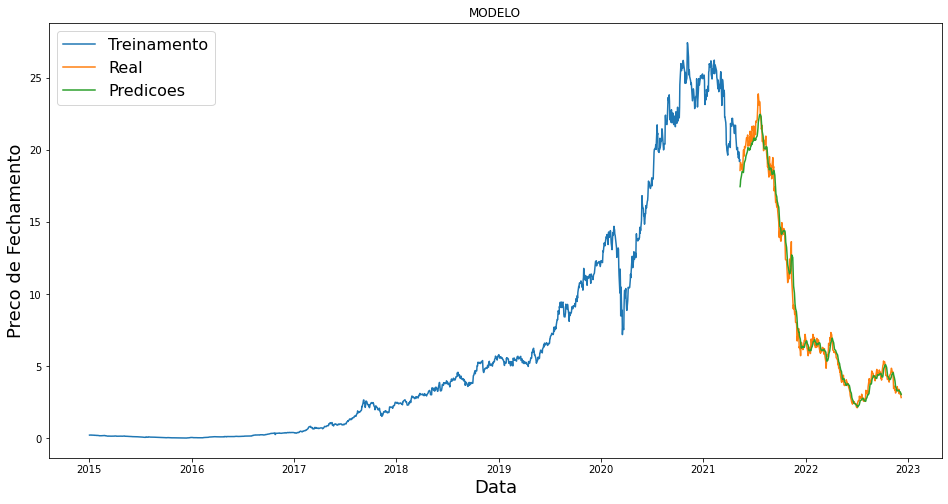

In [37]:
plt.figure(figsize=(16,8))
plt.title('MODELO')
plt.xlabel('Data', fontsize=18)
plt.ylabel("Preco de Fechamento", fontsize=18)
plt.plot(training['Close'])
plt.plot(df_test[['Close', 'predicoes']])
plt.legend(['Treinamento', 'Real', 'Predicoes'], loc=2, prop={'size':16})
plt.show

Note que no inicio das predições os dados previstos(Linha Verde) ficaram um pouco distante em relação ao valor real da ação(Linha Laranja), no entanto, em sua maior parte a Linha Verde ficou em cima da Linha Laranja, significando que a predição conseguiu um resultado bem positivo, fato que podemos confirmar com um Erro Quadratico Medio(RMSE) de 1 centavo e um Coeficiente de Determinação(R2) de 0.99.